In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




In [2]:
def show(data, const_axis, const_val, x_axis, y_axis, z_axis, colour="gray", z_min=-2, z_max=2, title=None):
    data = data.loc[data[const_axis] == const_val]
    data = data.pivot(columns=x_axis, index=y_axis, values=z_axis)
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=colour, vmin=z_min, vmax=z_max)    

    plt.title(title)
    plt.tight_layout()
    return plt.show(fig)

In [3]:
full_data = pd.read_parquet("Sleipner_4D_Seismic_Small.parquet.gzip", engine = "pyarrow")
# Calculate differences
full_data['01-94'] = full_data['01'] - full_data['94']
full_data['06-01'] = full_data['06'] - full_data['01']
full_data['06-94'] = full_data['06'] - full_data['94']


Analyzing year range: 01-94
Analyzing year range: 06-01
Analyzing year range: 06-94


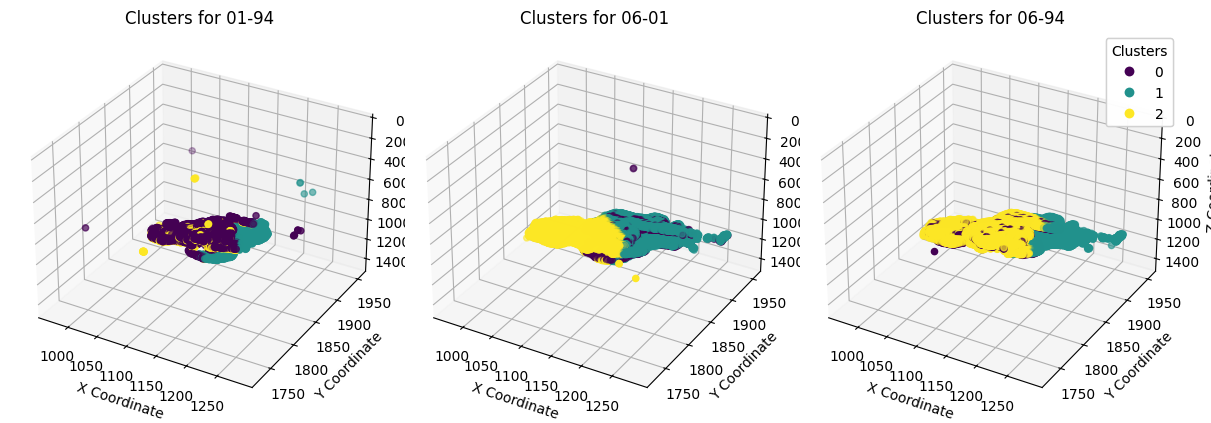

In [15]:
STD_THRESHOLD = 7

# Initialize figure for plotting
fig = plt.figure(figsize=(12, 8))

# Loop through the difference columns
for i, year_range in enumerate(['01-94', '06-01', '06-94']):
    print(f"Analyzing year range: {year_range}")

    # Calculate the threshold based on the current year range
    threshold = full_data[year_range].std() * STD_THRESHOLD

    # Find significant changes where the absolute difference exceeds the threshold
    significant_changes = full_data[(full_data[year_range].abs() > threshold)].copy()

    # Drop the original year columns as they are not needed for clustering
    significant_changes = significant_changes.drop(['94', '01', '06'], axis=1)

    # Filter out rows where 'z' is not between the 30th and 70th percentile
    significant_changes = significant_changes[(significant_changes['z'] >= full_data['z'].quantile(0.3)) & 
                                              (significant_changes['z'] <= full_data['z'].quantile(0.7))]

    # Scale the data
    scaler = StandardScaler()
    # Including the year_range column for scaling to use it for coloring the plot
    features_to_scale = ['x', 'y', 'z', year_range] if year_range in significant_changes else ['x', 'y', 'z']
    significant_changes_scaled = scaler.fit_transform(significant_changes[features_to_scale])

    # Cluster the data using the optimal k determined previously
    kmeans_optimal = KMeans(n_clusters=3, init='k-means++', random_state=42)
    clusters = kmeans_optimal.fit_predict(significant_changes_scaled)

    # Add the cluster assignment back to the significant_changes DataFrame
    significant_changes['Cluster'] = clusters

    # Add a subplot for each difference column
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')

    # Scatter plot for different clusters
    scatter = ax.scatter(significant_changes['x'], significant_changes['y'], significant_changes['z'],
                         c=significant_changes['Cluster'], cmap='viridis', marker='o')

    # Customize the subplot
    ax.set_title(f'Clusters for {year_range}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')

    # Set the same scale for all subplots
    ax.set_xlim(full_data['x'].min(), full_data['x'].max())
    ax.set_ylim(full_data['y'].min(), full_data['y'].max())
    ax.set_zlim(full_data['z'].min(), full_data['z'].max())
    ax.invert_zaxis()

# Outside the loop, add a legend and show the plot
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()